In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
from scipy.stats import gaussian_kde
sns.set_context('poster')
sns.set_palette('colorblind')

In [2]:
ati = pd.read_csv('../data/atium.csv', index_col=0)
ati = ati[ati.eye_flag != 3]
kics = ati.KIC.values
print(f'Working with {len(ati)} stars')

Working with 94 stars


In [3]:
%%time
d = '/home/oliver/PhD/mnt/RDS/malatium/models/'
post_pa = []
for idx, kic in enumerate(kics):
    try:
        post_pa.append(pd.read_csv(f"{d}{int(kic)}_samples.csv")['P_A'])
    except FileNotFoundError:
        print(f'File not found for index {idx}')
        ati.drop(index=idx, inplace=True)
        continue               

File not found for index 58
File not found for index 75
CPU times: user 16 s, sys: 1.92 s, total: 17.9 s
Wall time: 18.1 s


In [4]:
bins = np.linspace(0, 1, 100)
hists = np.array([np.histogram(n, bins=bins, density=True)[0] for n in post_pa])

### Read in models & make selection

In [14]:
stan = pd.read_hdf('../data/jvs_models/standard_population.h5', key='sample', mode='r')
ro = pd.read_hdf('../data/jvs_models/rocrit_population.h5', key='sample', mode='r')

## Temperature cut

In [19]:
stan = stan[stan.Teff <= 6500]
ro = ro[ro.Teff <= 6500]

In [20]:
cols = ['Teff', 'period', 'age']
bound_s = [(stan[par].min(), stan[par].max()) for par in cols]
bound_ro = [(ro[par].min(), ro[par].max()) for par in cols]

### Membership

In [21]:
c1 = ati.copy(deep=True)
sel = []

cols = ['Teff', 'P', 'age', 'modmass']
for idx in c1.index:
    par = [c1.loc[idx][col] for col in cols]
    if not all(b[0] < v < b[1] for v, b in list(zip(par, bound_s))):
        c1.drop(index=idx, inplace=True)
        sel.append(False)
    elif not all(b[0] < v < b[1] for v, b in list(zip(par, bound_ro))):
        c1.drop(index=idx, inplace=True)
        sel.append(False)
    else:
        sel.append(True)
        pass

In [22]:
hists_sel = hists[sel]
sg = c1['hrclass'] == 'SG'
ms = c1['hrclass'] == 'MS'
h = c1['hrclass'] == 'H'
print(f'We have {len(c1[sg])} Sub-Giant stars.')
print(f'We have {len(c1[h])} Hot stars.')
print(f'We have {len(c1[ms])} Main-Sequence stars.')

We have 4 Sub-Giant stars.
We have 19 Hot stars.
We have 55 Main-Sequence stars.


### Convergence

In [23]:
c2 = c1.copy(deep=True)
sel = (c2.neff_split > 1000) & (c2.rhat_flag != 'rhat_1')
hists_sel_cov = hists_sel[sel]
sg = c2[sel]['hrclass'] == 'SG'
ms = c2[sel]['hrclass'] == 'MS'
h = c2[sel]['hrclass'] == 'H'
print(f'We have {len(c2[sel][sg])} Sub-Giant stars.')
print(f'We have {len(c2[sel][h])} Hot stars.')
print(f'We have {len(c2[sel][ms])} Main-Sequence stars.')

We have 4 Sub-Giant stars.
We have 17 Hot stars.
We have 45 Main-Sequence stars.


## Plots

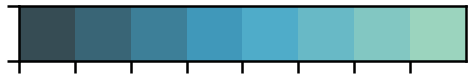

In [25]:
from matplotlib.colors import ListedColormap
snsmap = sns.color_palette('GnBu_d',8)
cmap = ListedColormap(snsmap.as_hex())
sns.palplot(snsmap)

## Comp

In [29]:
old_stan = pd.read_csv('../data/jvs_models/standard_model.csv', index_col=None)
old_stan.rename(columns={'# Teff(K)':'Teff', ' Prot(days)':'period',
                         ' Age(Gyr)':'Age',' Mass(Msun)':'M', ' Ro ':'Ro'}, inplace=True)
old_ro = pd.read_csv('../data/jvs_models/rocrit_model.csv', index_col=None)
old_ro.rename(columns={'#Teff(K)':'Teff', ' Prot(days)':'period',
                         ' Age(Gyr)':'Age',' Mass(Msun)':'M', ' Ro ':'Ro'}, inplace=True)

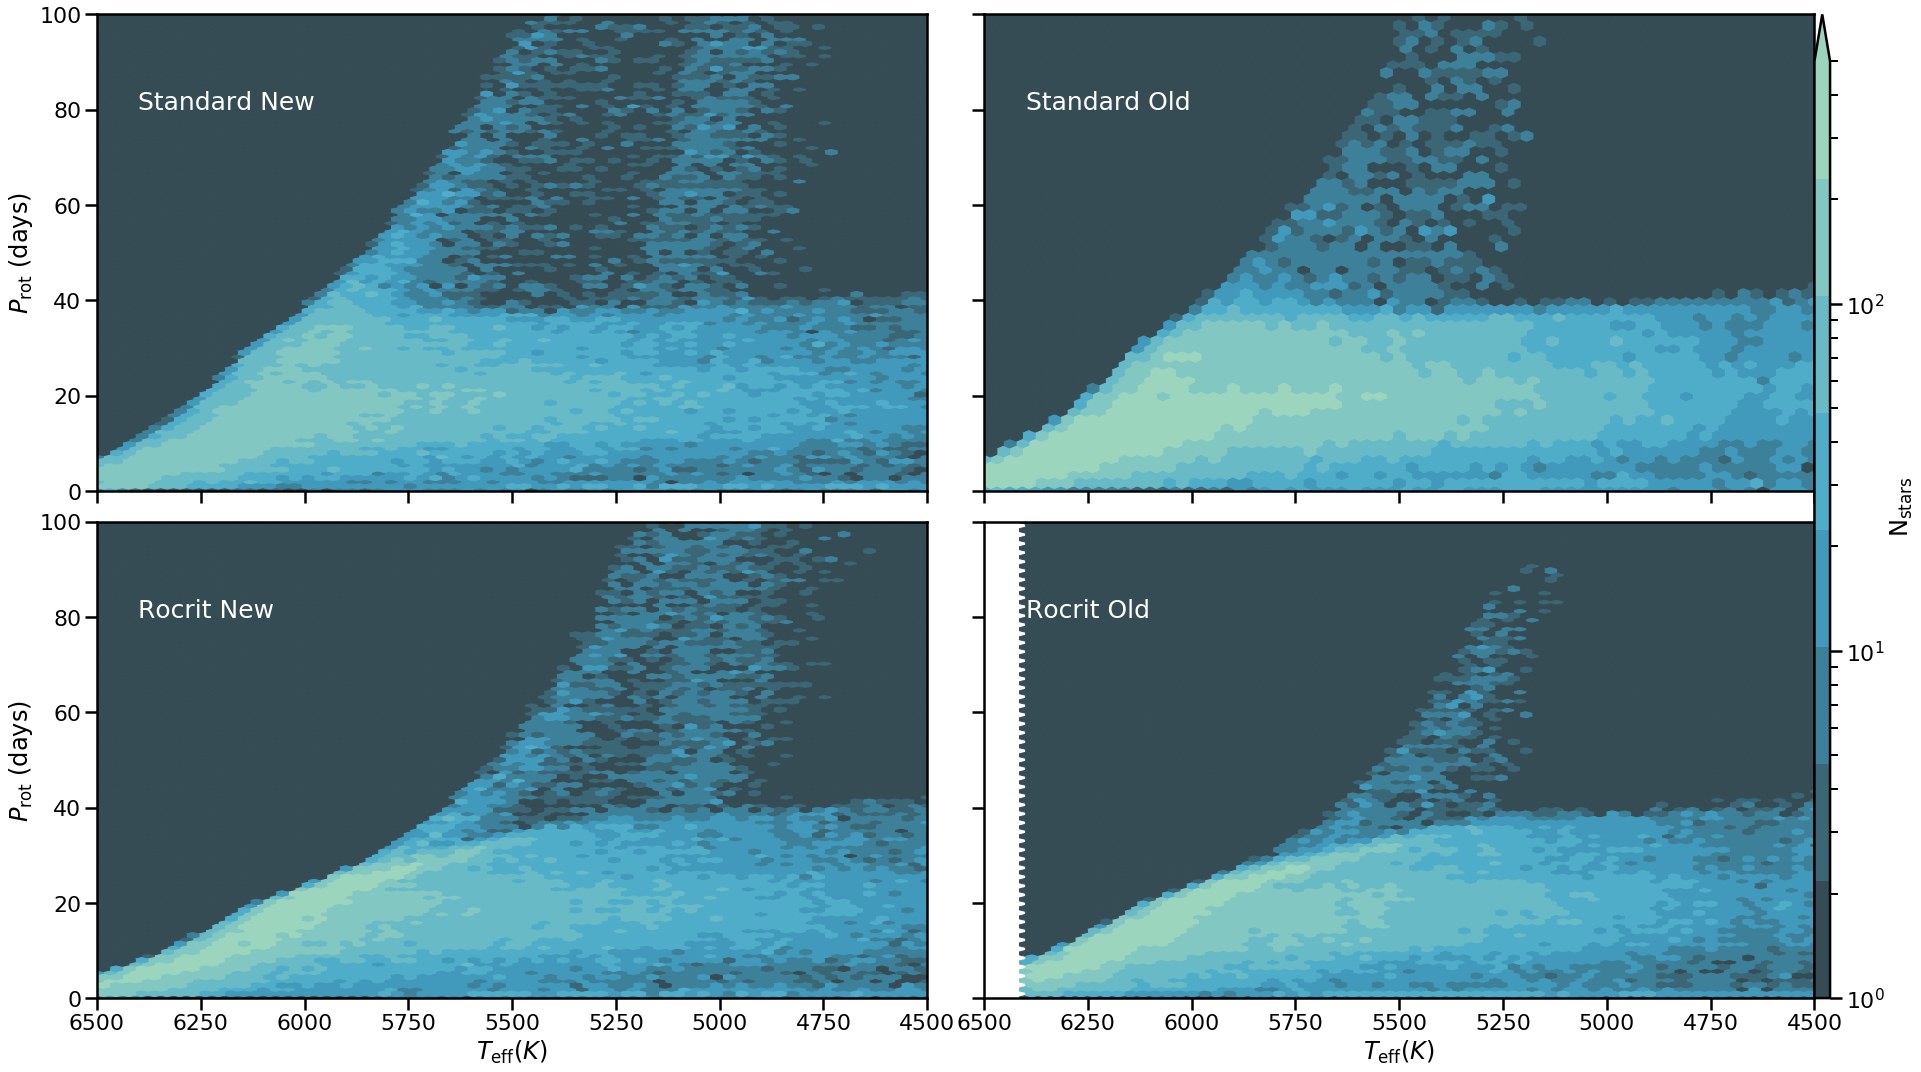

In [64]:
fig, axes = plt.subplots(2,2, figsize=(30,15), sharex=True, sharey=True)

axes[0,0].hexbin(stan.Teff, stan.period, cmap=cmap, bins='log', vmin=1, vmax=500)
axes[0,0].text(6400, 80, s='Standard New', c='w', fontsize=25)
axes[0,1].hexbin(old_stan.Teff, old_stan.period, cmap=cmap, bins='log', vmin=1, vmax=500)
axes[0,1].text(6400, 80, s='Standard Old', c='w', fontsize=25)
axes[1,0].hexbin(ro.Teff, ro.period, cmap=cmap, bins='log', vmin=1, vmax=500)
axes[1,0].text(6400, 80, s='Rocrit New', c='w', fontsize=25)
c = axes[1,1].hexbin(old_ro.Teff, old_ro.period, cmap=cmap, bins='log', vmin=1, vmax=500)
axes[1,1].text(6400, 80, s='Rocrit Old', c='w', fontsize=25)

for ax in axes.ravel():
    ax.invert_xaxis()
    ax.set_ylim(0, 100)
    ax.set_xlim(6500, 4500)

axes[0,0].set_ylabel(r'$P_{\rm rot}$ (days)')
axes[1,0].set_ylabel(r'$P_{\rm rot}$ (days)')
axes[1,0].set_xlabel(r'$T_{\rm eff} (K)$')
axes[1,1].set_xlabel(r'$T_{\rm eff} (K)$')
fig.tight_layout()
fig.colorbar(c,ax=axes.ravel(), label=r'$\rm{N_{\rm stars}}$', pad=0,aspect=60, extend='max')
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/model_comparison.png', bbox_inches='tight', dpi=300)
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/model_comparison.pdf', bbox_inches='tight', rasterized=True)
plt.show()

## Data plots

In [42]:
sg = ati['hrclass'] == 'SG'
ms = ati['hrclass'] == 'MS'
h = ati['hrclass'] == 'H'

In [47]:
fsel = ati['KIC'].isin(c2[sel]['KIC'])
f_post_pa = np.array(post_pa)[fsel]
fin = ati[fsel]
Ps = np.median(f_post_pa, axis=1)
exc = ati.loc[~ati['KIC'].isin(fin.KIC)]
feh = fin.loc[np.abs(fin.feh.values) > 0.4]
excfeh = exc.loc[np.abs(exc.feh.values) > 0.4]

In [52]:
ati.P.max() + 10

63.555235074569

In [54]:
stan_p = stan[(stan.Teff < 6500) & (stan.Teff > 5000) & (stan.period < 65)]
ro_p = ro[(ro.Teff < 6500) & (ro.Teff > 5000) & (ro.period < 65)]

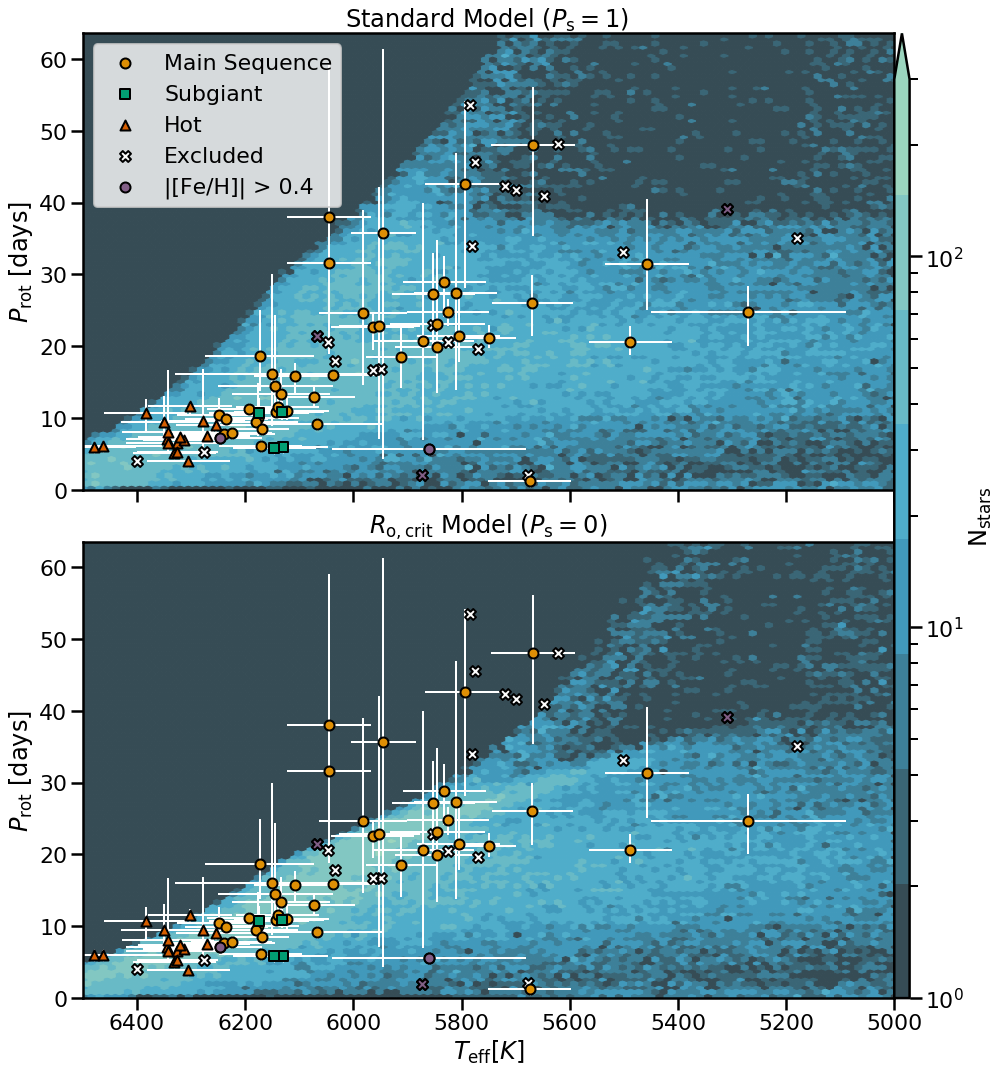

In [60]:
fig, axes = plt.subplots(2,1, figsize=(15,15), sharex=True, sharey=True)
# ax = plt.gca()
ax = axes[0]
ax.hexbin(stan_p.Teff, stan_p.period, cmap=cmap, bins='log', vmin=1, vmax=300)
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(fin.Teff[ms], fin.P[ms], marker='o', s=100,zorder=3, ec='k', lw='2', label='Main Sequence')
ax.scatter(fin.Teff[sg], fin.P[sg], marker=',', s=100,zorder=3, ec='k', lw='2', label='Subgiant')
ax.scatter(fin.Teff[h], fin.P[h], marker='^', s=100,zorder=3, ec='k', lw='2', label='Hot')

# Excluded
ax.scatter(exc.Teff, exc.P, marker='X', s=120,zorder=2, ec='k', c='w', lw=2, label='Excluded')
# FeH
ax.scatter(excfeh.Teff, excfeh.P, marker='X', s=120,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2)
ax.scatter(feh.Teff, feh.P, marker='o', s=100,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2, label='|[Fe/H]| > 0.4')
ax.errorbar(fin.Teff, fin.P, c='w', lw=2, xerr=fin.eTeff, yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylim(0, ati.P.max() + 10)
ax.set_xlim(6500, 5000)
ax.set_ylabel(r'$P_{\rm rot}$ [days]')
# ax.set_xlabel(r'$T_{\rm eff} (K)$')
ax.set_title(r'Standard Model ($P_{\rm s} = 1$) ')
ax.legend(loc='upper left')

ax = axes[1]
c = ax.hexbin(ro_p.Teff, ro_p.period, cmap=cmap, bins='log', vmin=1, vmax=300)
ax.invert_xaxis()
ax.scatter(np.nan, np.nan)
ax.scatter(fin.Teff[ms], fin.P[ms], marker='o', s=100,zorder=3, ec='k', lw='2', label='Main Sequence')
ax.scatter(fin.Teff[sg], fin.P[sg], marker=',', s=100,zorder=3, ec='k', lw='2', label='Subgiant')
ax.scatter(fin.Teff[h], fin.P[h], marker='^', s=100,zorder=3, ec='k', lw='2', label='Hot')

ax.scatter(exc.Teff, exc.P, marker='X', s=120,zorder=2, ec='k', c='w', lw=2, label='Excluded')
ax.scatter(excfeh.Teff, excfeh.P, marker='X', s=120,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2)
ax.scatter(feh.Teff, feh.P, marker='o', s=100,zorder=5, ec='k', 
           c=sns.xkcd_rgb["dusty purple"], lw=2, label='|[Fe/H]| > 0.4')

ax.errorbar(fin.Teff, fin.P, c='w', lw=2, xerr=fin.eTeff, yerr=[fin.l_P, fin.u_P], fmt='|', zorder=1)
ax.set_ylim(0, ati.P.max() + 10)
ax.set_xlim(6500, 5000)
ax.set_ylabel(r'$P_{\rm rot}$ [days]')
ax.set_xlabel(r'$T_{\rm eff} [K]$')
ax.set_title(r'$R_{\rm o,crit}$ Model ($P_{\rm s} = 0$)')
# ax.legend(loc='upper left')

fig.tight_layout()
fig.colorbar(c, ax=axes.ravel(),label=r'$\rm{N_{\rm stars}}$', pad=0, aspect=60, extend='max')
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/fullsample.png', bbox_inches='tight', dpi=300)
plt.savefig('/home/oliver/Dropbox/Apps/Overleaf/Malatium/Images/fullsample.pdf', bbox_inches='tight', rasterized=True)
plt.show()